<a href="https://colab.research.google.com/github/byambaa1982/NN_model_on_TimeSeriesDataset/blob/master/NN_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from math import sqrt
from numpy import array
from numpy import mean
from pandas import DataFrame
from pandas import concat
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot

In [0]:
# split a dataset into train/test sets
def train_test_split(data, n_test):
	return data[:-n_test], data[-n_test:]

In [0]:
# transform list into supervised learning format
def series_to_supervised(data, n_in=1, n_out=1):
	df = pd.DataFrame(data)
	cols = list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
	# put it all together
	agg = concat(cols, axis=1)
	# drop rows with NaN values
	agg.dropna(inplace=True)
	return agg.values

In [0]:
 
# root mean squared error or rmse
def measure_rmse(actual, predicted):
	return sqrt(mean_squared_error(actual, predicted))
 
# difference dataset
def difference(data, order):
	return [data[i] - data[i - order] for i in range(order, len(data))]
 
# fit a model
def model_fit(train, config):
	# unpack config
	n_input, n_nodes, n_epochs, n_batch, n_diff = config
	# prepare data
	if n_diff > 0:
		train = difference(train, n_diff)
	# transform series into supervised format
	data = series_to_supervised(train, n_in=n_input)
	# separate inputs and outputs
	train_x, train_y = data[:, :-1], data[:, -1]
	# define model
	model = Sequential()
	model.add(Dense(n_nodes, activation='relu', input_dim=n_input))
	model.add(Dense(1))
	model.compile(loss='mse', optimizer='adam')
	# fit model
	model.fit(train_x, train_y, epochs=n_epochs, batch_size=n_batch, verbose=0)
	return model
 
# forecast with the fit model
def model_predict(model, history, config):
	# unpack config
	n_input, _, _, _, n_diff = config
	# prepare data
	correction = 0.0
	if n_diff > 0:
		correction = history[-n_diff]
		history = difference(history, n_diff)
	# shape input for model
	x_input = array(history[-n_input:]).reshape((1, n_input))
	# make forecast
	yhat = model.predict(x_input, verbose=0)
	# correct forecast if it was differenced
	return correction + yhat[0]
 
# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
	predictions = list()
	# split dataset
	train, test = train_test_split(data, n_test)
	# fit model
	model = model_fit(train, cfg)
	# seed history with training dataset
	history = [x for x in train]
	# step over each time-step in the test set
	for i in range(len(test)):
		# fit model and make forecast for history
		yhat = model_predict(model, history, cfg)
		# store forecast in list of predictions
		predictions.append(yhat)
		# add actual observation to history for the next loop
		history.append(test[i])
	# estimate prediction error
	error = measure_rmse(test, predictions)
	print(' > %.3f' % error)
	return error, predictions, test
 
# score a model, return None on failure
def repeat_evaluate(data, config, n_test, n_repeats=10):
	# convert config to a key
	key = str(config)
	# fit and evaluate the model n times
	scores = [walk_forward_validation(data, n_test, config) for _ in range(n_repeats)]
	# summarize score
	result = mean(scores)
	print('> Model[%s] %.3f' % (key, result))
	return (key, result)
 
# grid search configs
def grid_search(data, cfg_list, n_test):
	# evaluate configs
	scores = [repeat_evaluate(data, cfg, n_test) for cfg in cfg_list]
	# sort configs by error, asc
	scores.sort(key=lambda tup: tup[1])
	return scores
 

In [0]:
def data_to_csv(df):
  df=df[['Temperature','time']]
  df['time'] = pd.to_datetime(df['time'])
  df.time=df.time.map(lambda x:str(x))
  df=df.set_index('time')
  return df.to_csv('csv_file_1.csv')

In [0]:
df=pd.read_csv('/content/tmdata.csv')

In [21]:
data_to_csv(df)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [0]:
# define dataset
series = pd.read_csv('csv_file.csv', header=0, index_col=0)
# series['Pass']=series['Passengers']
data = series.values
# data split
n_test = 12
# model configs

In [0]:
cfg=[20, 50, 100, 1, 0]

In [24]:
walk_forward_validation(data[:110], n_test, cfg)

 > 0.120


0.11958404018800274

In [40]:
true_values=walk_forward_validation(data[:110], n_test, cfg)[2]
predictions=walk_forward_validation(data[:110], n_test, cfg)[1]

 > 0.071
 > 0.043


No handles with labels found to put in legend.


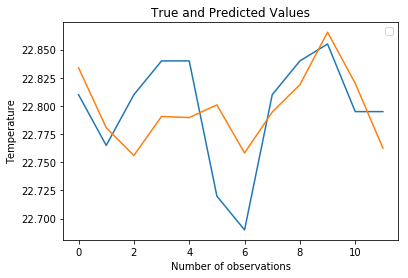

In [41]:
# pyplot.plot([i for i in y[8600:8615]])
pyplot.plot([x for x in true_values])
pyplot.plot([x for x in predictions])
plt.title('True and Predicted Values')
plt.xlabel('Number of observations')
plt.ylabel('Temperature')
plt.legend()
pyplot.show()

In [39]:
true_values

0.06478218990506251